# cadCAD object mapping proposals

Note: the intent of this notebooks is to provocate and to give food for brainstorming

In [0]:
%%capture
!pip install cadCAD
import inspect

## Function map

On this proposal, we create cadCAD mappings for user functions. This is done via the Policy and StateUpdate functions applied to the user ones, and by using the State, Params and PolicyInput objects to create wrappers.

To **create an cadCAD policy function**, we use the following:

```python
policy_function = Policy(user_function, *policy_inputs, **arguments_mappings)
```

Where the arguments_mappings must match the function signature: ie, an function given by ``f = lambda x, y: x * y`` must be wrapped by:

```python
policy_function = Policy(f, PolicyInput('input_name'), x=State('x'), y=State('y'))
```

As for the **State Update Functions**, we would use:

```python
state_update = StateUpdate(user_function, variable, **arguments_mappings)
```

I`ve written an example with batteries below.

In [0]:
# Some code for an quick prototype

State = lambda x: ('prev_state', x)
Params = lambda x: ('params', x)
PolicyInput = lambda x: ('policy_input', x)
Policy = lambda f, *args, **kwargs: None
StateUpdate = lambda f, state, **kwargs: None 


def Policy(f, *args, **kwargs):
  policy_function = None
  def policy_function(params, substep, state_history, prev_state):
    kwargs_map = {}
    for key, value in kwargs.items():
      kwarg_type = value[0]
      kwarg_value = value[1]
      if kwarg_type == 'prev_state':
        kwargs_map[key] = prev_state[kwarg_value]
      elif kwarg_type == 'params':
        kwargs_map[key] = params[kwarg_value]
    function_output = f(**kwargs_map)
    policy_input = args[0][1]
    return {policy_input: function_output}
  return policy_function

def StateUpdate(f, variable, **kwargs):
  state_update = None
  def state_update(params, substep, state_history, prev_state, policy_input):
    kwargs_map = {}
    for key, value in kwargs.items():
      kwarg_type = value[0]
      kwarg_value = value[1]
      if kwarg_type == 'prev_state':
        kwargs_map[key] = prev_state[kwarg_value]
      elif kwarg_type == 'params':
        kwargs_map[key] = params[kwarg_value]
      elif kwarg_type == 'policy_input':
        kwargs_map[key] = policy_input[kwarg_value]
    function_output = f(**kwargs_map)
    return (variable, function_output)
  return state_update
   

### Example of real usage

**User functions**

In [0]:
## User functions
def logistic_map(x: float, a: float) -> float:
  return a * x * (1 - x)

def update_population(x: float) -> float:
  return x

**PSUB building**

In [0]:
partial_state_update_blocks = [
  {
      'policies': {
          'logistic_map': Policy(logistic_map,
                                 PolicyInput('new_population'),
                                 x=State('population'),
                                 a=Params('control_parameter'))
      },
      'variables': {
          'population': StateUpdate(update_population, 
                                    'population',
                                    x=PolicyInput('new_population'))
      }
  }
]

**Quick test**

In [0]:
logistic_map(0.7, 2.7)
policy = partial_state_update_blocks[0]['policies']['logistic_map']
print(policy({'control_parameter': 3.7}, {}, {}, {'population': 0.7}))
print(logistic_map(0.7, 3.7))

{'new_population': 0.777}
0.777


**Actual cadCAD usage**

In [0]:
from cadCAD.configuration import Configuration
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

genesis_state = {
    'population': 0.01
}

sim_config = (
    {
        'N': 1,
        'T': range(1000), # number of timesteps
        'M': {'control_parameter': 3.7},
    }
)


config = Configuration(
    sim_config=sim_config,
    initial_state=genesis_state,
    partial_state_update_blocks=partial_state_update_blocks
)

exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.multi_proc)
executor = Executor(exec_context, [config]) # Pass the configuration object inside an array
raw_result = executor.execute() # The `execute()` method returns a tuple; its first elements contains the raw results
data = pd.DataFrame(raw_result[0][0])


                            __________   ____ 
          ________ __ _____/ ____/   |  / __ \
         / ___/ __` / __  / /   / /| | / / / /
        / /__/ /_/ / /_/ / /___/ ___ |/ /_/ / 
        \___/\__,_/\__,_/\____/_/  |_/_____/  
        by BlockScience
        
Execution Mode: multi_proc: [<cadCAD.configuration.Configuration object at 0x7f718a965908>]
Configurations: [<cadCAD.configuration.Configuration object at 0x7f718a965908>]


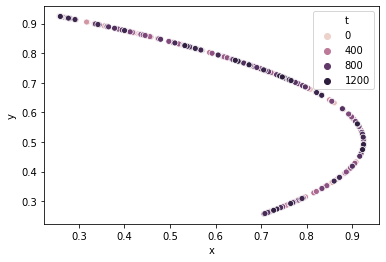

In [0]:
n = 3
t = data.timestep[3::n].values
x = data.population[4::n].values
y = data.population[3::n].values
new_data = pd.DataFrame({'t': t, 'x': x, 'y': y})
sns.scatterplot(data=new_data, x='x', y='y', hue='t')

## Class map


```python
@policy_function
def user_function(x, a, b, c):
  return y
```

## Decorators

Another analogous way of doing the same of above, would be using python decorators with parameters

```
@policy(PolicyInput('user_signal'),
        x=State('state_of_x'),
        a=Param('param_a'))
def user_function(x, a, b=1.5, c=2.0):
  return output
```

### Quick prototype

In [0]:
# Some code for an quick prototype
import functools


State = lambda x: ('prev_state', x)
Params = lambda x: ('params', x)
PolicyInput = lambda x: ('policy_input', x)
Policy = lambda f, *args, **kwargs: None
StateUpdate = lambda f, state, **kwargs: None 


def generate_policy(*args, **kwargs):
  def decorator(f):
    def policy_function(params, substep, state_history, prev_state):
      kwargs_map = {}
      for key, value in kwargs.items():
        kwarg_type = value[0]
        kwarg_value = value[1]
        if kwarg_type == 'prev_state':
          kwargs_map[key] = prev_state[kwarg_value]
        elif kwarg_type == 'params':
          kwargs_map[key] = params[kwarg_value]
      function_output = f(**kwargs_map)
      policy_input = args[0][1]
      return {policy_input: function_output}
    return policy_function
  return decorator

def generate_state_update(variable, **kwargs):
  def decorator(f):
    def state_update(params, substep, state_history, prev_state, policy_input):
      kwargs_map = {}
      for key, value in kwargs.items():
        kwarg_type = value[0]
        kwarg_value = value[1]
        if kwarg_type == 'prev_state':
          kwargs_map[key] = prev_state[kwarg_value]
        elif kwarg_type == 'params':
          kwargs_map[key] = params[kwarg_value]
        elif kwarg_type == 'policy_input':
          kwargs_map[key] = policy_input[kwarg_value]
      function_output = f(**kwargs_map)
      return (variable, function_output)
    return state_update
  return decorator
   

### User input

In [0]:
## User functions
@generate_policy(PolicyInput('new_population'),
                 x=State('population'),
                 a=Params('control_parameter'))
def logistic_policy(x: float, a: float) -> float:
  return a * x * (1 - x)

@generate_state_update('population',
                       x=PolicyInput('new_population'))
def logistic_update(x: float) -> float:
  return x

In [0]:
print(logistic_policy({'control_parameter': 3.7}, {}, {}, {'population': 0.7}))
print(logistic_map(0.7, 3.7))

{'new_population': 0.777}
0.777


### Actual cadCAD usage


                            __________   ____ 
          ________ __ _____/ ____/   |  / __ \
         / ___/ __` / __  / /   / /| | / / / /
        / /__/ /_/ / /_/ / /___/ ___ |/ /_/ / 
        \___/\__,_/\__,_/\____/_/  |_/_____/  
        by BlockScience
        
Execution Mode: multi_proc: [<cadCAD.configuration.Configuration object at 0x7f718b6336a0>]
Configurations: [<cadCAD.configuration.Configuration object at 0x7f718b6336a0>]


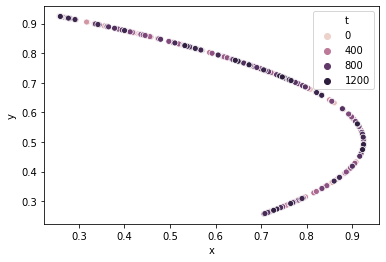

In [0]:
from cadCAD.configuration import Configuration
from cadCAD.engine import ExecutionMode, ExecutionContext, Executor
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


partial_state_update_blocks = [
  {
      'policies': {
          'logistic_map': logistic_policy
      },
      'variables': {
          'population': logistic_update
      }
  }
]

genesis_state = {
    'population': 0.01
}

sim_config = (
    {
        'N': 1,
        'T': range(1000), # number of timesteps
        'M': {'control_parameter': 3.7},
    }
)


config = Configuration(
    sim_config=sim_config,
    initial_state=genesis_state,
    partial_state_update_blocks=partial_state_update_blocks
)

exec_mode = ExecutionMode()
exec_context = ExecutionContext(exec_mode.multi_proc)
executor = Executor(exec_context, [config]) # Pass the configuration object inside an array
raw_result = executor.execute() # The `execute()` method returns a tuple; its first elements contains the raw results
data = pd.DataFrame(raw_result[0][0])
n = 3
t = data.timestep[3::n].values
x = data.population[4::n].values
y = data.population[3::n].values
new_data = pd.DataFrame({'t': t, 'x': x, 'y': y})
sns.scatterplot(data=new_data, x='x', y='y', hue='t')